# Prompt Engineering with GPT-J

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import re
from sklearn.metrics import accuracy_score, f1_score


%matplotlib inline

### Load Dataset

In [2]:
# Read the data
data_directory = 'data/'
train = pd.read_csv(data_directory + 'train.csv')
test = pd.read_csv(data_directory + 'test.csv')

# Preprocess the data
def preprocess(data):
    # Remove URLs, linebreaks, and extra spaces
    data['text'] = data['text'].str.replace(r'http\S+', '', regex=True)
    data['text'] = data['text'].str.replace(r'\\n', ' ', regex=True)
    data['text'] = data['text'].str.replace(r'\s+', ' ', regex=True)

    return data

train = preprocess(train)
test = preprocess(test)

# Split train into 10% dtrain and 90% dtest, stratified by target
dtrain, dtest = train_test_split(train, test_size=0.9, random_state=42, stratify=train['target'])

In [3]:
dtrain

,id,keyword,location,text,target
4858,6917,mass%20murderer,Leaving Bikini Bottom,seeing as how this person is a mass murderer a...,0
5644,8049,refugees,NaN,recap/ 12000 Nigerian refugees repatriated fro...,1
2541,3646,desolation,Chile,Fear and panic in the air I want to be free Fr...,0
6135,8753,siren,"Tampa, FL",A demoness with the voice of an angel. Like a ...,0
6434,9207,suicide%20bombing,NaN,'Suicide bombing at [location named]...' #prem...,1
...,...,...,...,...,...
6421,9181,suicide%20bomber,NaN,@bbclaurak Why is no one talking about the ris...,1
7566,10815,wrecked,United States,Cramer: Iger's 3 words that wrecked Disney's ...,0
7452,10665,wounds,"Cleveland, OH",If time heals all wounds how come the belly bu...,0
6284,8976,storm,"Charlotte, NC",Severe T-storm Warning for Union County ~3:45p...,1


In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,7613.0,NaN,NaN,NaN,5441.934848,3137.11609,1.0,2734.0,5408.0,8146.0,10873.0
keyword,7552,221,fatalities,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,5080,3341,USA,104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
text,7613,6971,Watch This Airport Get Swallowed Up By A Sands...,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
target,7613.0,NaN,NaN,NaN,0.42966,0.49506,0.0,0.0,0.0,1.0,1.0


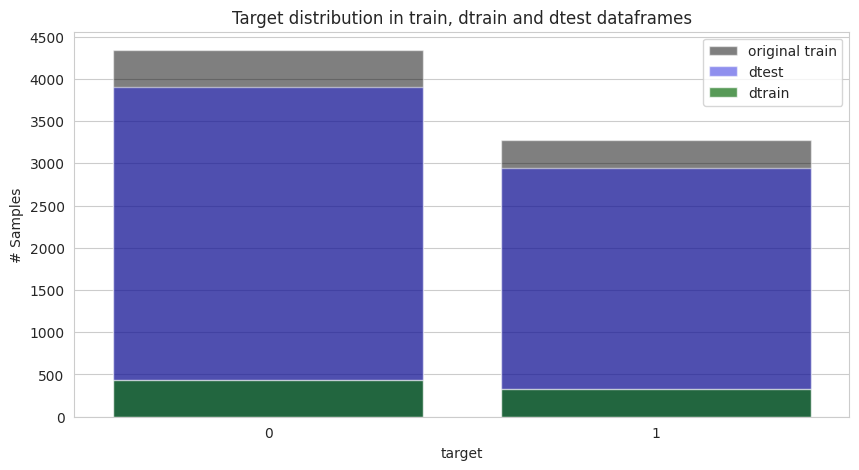

In [6]:
# Plot the target distribution in train, dtrain and dtest dataframes in the same plot

sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.countplot(x='target', data=train, ax=ax, color='black', alpha=0.5)
sns.countplot(x='target', data=dtest, ax=ax, color='blue', alpha=0.5)
sns.countplot(x='target', data=dtrain, ax=ax, color='green', alpha=0.7)

ax.set_title('Target distribution in train, dtrain and dtest dataframes')
ax.legend(['original train', 'dtest', 'dtrain'])

ax.set_yticks(np.arange(0, 5000, 500))
ax.set_ylabel('# Samples')
plt.show()


In [7]:
# Print first 10 tweets from dtrain
for i in range(10):
    print(dtrain['text'].iloc[i], 'target:', dtrain['target'].iloc[i])

seeing as how this person is a mass murderer and has like FBI CIA grade equipment to do evil shit. target: 0
recap/ 12000 Nigerian refugees repatriated from Cameroon  target: 1
Fear and panic in the air I want to be free From desolation and despair And I feel like everything I sow ?  target: 0
A demoness with the voice of an angel. Like a siren's call beckoning me to the void. Don't ?? on thisÛ_  target: 0
'Suicide bombing at [location named]...' #premonitions  target: 1
Had an awesome time visiting the CFC head office the ancop site and ablaze. Thanks to Tita Vida for taking care of us ?? target: 0
collapsed the moment i got home last night lol target: 0
@Michael5SOS haha so would you say its so hot your balls are burning off???? target: 1
Why does my family have to ruin something that is actually going good for me?? target: 0
National Briefing | West: California: Spring Oil Spill Estimate Grows: Documents released on Wednesday d... (NYT) target: 1


### Prompt Engineering

#### Load the pre-trained GPT-J model and tokenizer

In [8]:
import transformers
import torch
import pandas as pd
from tqdm.notebook import tqdm
from gpt_quant import GPTJForCausalLM
from transformers import AutoTokenizer


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/abdessalem/Desktop/Projects/prompt-engineering/venv/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so
CUDA SETUP: Loading binary /home/abdessalem/Desktop/Projects/prompt-engineering/venv/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so...


In [9]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B")
model = GPTJForCausalLM.from_pretrained("hivemind/gpt-j-6B-8bit", device_map="balanced")
model.to("cpu")

lm_head Linear(in_features=4096, out_features=50400, bias=True)
k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, bias=False)
out_proj Linear(in_features=4096, out_features=4096, bias=False)
fc_in Linear(in_features=4096, out_features=16384, bias=True)
fc_out Linear(in_features=16384, out_features=4096, bias=True)
k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, bias=False)
out_proj Linear(in_features=4096, out_features=4096, bias=False)
fc_in Linear(in_features=4096, out_features=16384, bias=True)
fc_out Linear(in_features=16384, out_features=4096, bias=True)
k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, b

GPTJForCausalLM(
  (transformer): GPTJModel(
    (wte): FrozenBNBEmbedding(50400, 4096)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-27): 28 x GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): FrozenBNBLinear(4096, 4096)
          (v_proj): FrozenBNBLinear(4096, 4096)
          (q_proj): FrozenBNBLinear(4096, 4096)
          (out_proj): FrozenBNBLinear(4096, 4096)
        )
        (mlp): GPTJMLP(
          (fc_in): FrozenBNBLinear(4096, 16384)
          (fc_out): FrozenBNBLinear(16384, 4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): FrozenBNBLinear(4096, 50400)
)

#### Zero-Shot Classification 

In [10]:
def create_prompt(tweet):

    prompt = f'''Classify the following tweets into one of the following categories: [Disaster, Not]\n\n
    Tweet: {tweet}\n
    Category:'''

    return prompt


def generate_output(prompt):

    # Tokenize the prompt
    sample = tokenizer(prompt, return_tensors='pt')
    sample = {k: v.to('cpu') for k, v in sample.items()}

    # Generate the output
    gen_tokens = model.generate(**sample, max_length=(sample['input_ids'].shape[-1]) + 1)
    
    return tokenizer.decode(gen_tokens[0])


In [11]:
# Get a random tweet where the target is 1
tweet = dtrain[dtrain.target == 1].sample(1).text.values[0]

# Create the prompt
prompt = create_prompt(tweet)

# Generate the output
output = generate_output(prompt)
print(output)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Classify the following tweets into one of the following categories: [Disaster, Not]


    Tweet: Now on #ComDev #Asia: Radio stations in #Bangladesh broadcasting #programs?to address the upcoming cyclone #komen 

    Category: Disaster


In [12]:
# Get a random tweet where the target is 0
tweet = dtrain[dtrain.target == 0].sample(1).text.values[0]

# Create the prompt
prompt = create_prompt(tweet)

# Generate the output
output = generate_output(prompt)
print(output)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Classify the following tweets into one of the following categories: [Disaster, Not]


    Tweet: fatality

    Category: Disaster


#### Few-Shot Classification

##### Prepare Prompt Dataset

In [13]:
# Define a list of prompt descriptions

prompt_descriptions = [
    "Classify the following tweets into one of the following categories: [Disaster, Not]\n\n", #Human-crafted
    "Your objective is to categorize the following tweets into two categories: Disaster or Not.\n\n", #Generated using first prompt
    "Your task is to classify the tweets provided below as either related to a Disaster or Not.\n\n", #Generated
    "Place the following tweets into one of two categories: Disaster or Not.\n\n", #Generated
    "You need to assign each of the tweets to one of two categories: Disaster or Not.\n\n", #Generated
    "Determine whether the following tweets are related to a Disaster or Not, and categorize them accordingly.\n\n", #Generated
]


def generate_prompt(ptweet, prompt_description):
    target_dict = {0: 'Not', 1: 'Disaster'}
    prompt = prompt_description


    # Get the first n tweets and their targets from df
    n = 5
    for row in dtrain.head(n).iterrows():
        tweet = row[1].text
        target = row[1].target
        target = target_dict[target]
        prompt += f'''Tweet: {tweet} \nCategory: {target}\n\n'''

    # Add the tweet to predict to the prompt
    prompt += f'''Tweet: {ptweet} \nCategory:'''
    return prompt

def create_dataset(n=10):
    dprompts = dtest.head(n).copy()
    for i,prompt_description in enumerate(prompt_descriptions):
        for row in dtest.head(n).iterrows():
            prompt = generate_prompt(row[1].text, prompt_description)
            dprompts['prompt_'+str(i)] = prompt

    
    dprompts['label'] = dprompts['target'].apply(lambda x: ' Disaster' if x == 1 else ' Not')

    return dprompts

dprompts = create_dataset()

In [14]:
dprompts.head()

,id,keyword,location,text,target,prompt_0,prompt_1,prompt_2,prompt_3,prompt_4,prompt_5,label
6804,9749,tragedy,MÌ©xico,I'm gunning down romance It never did a thing ...,0,Classify the following tweets into one of the ...,Your objective is to categorize the following ...,Your task is to classify the tweets provided b...,Place the following tweets into one of two cat...,You need to assign each of the tweets to one o...,Determine whether the following tweets are rel...,Not
7167,10270,war%20zone,NaN,#WorldWatchesFerguson #Florida @GovJayNixon @c...,1,Classify the following tweets into one of the ...,Your objective is to categorize the following ...,Your task is to classify the tweets provided b...,Place the following tweets into one of two cat...,You need to assign each of the tweets to one o...,Determine whether the following tweets are rel...,Disaster
3518,5029,eyewitness,Somewhere in Jersey,I liked a @YouTube video Mini Pony packs a pun...,0,Classify the following tweets into one of the ...,Your objective is to categorize the following ...,Your task is to classify the tweets provided b...,Place the following tweets into one of two cat...,You need to assign each of the tweets to one o...,Determine whether the following tweets are rel...,Not
6809,9755,tragedy,Jamaica,Rt hirochii0: There is no country that making ...,1,Classify the following tweets into one of the ...,Your objective is to categorize the following ...,Your task is to classify the tweets provided b...,Place the following tweets into one of two cat...,You need to assign each of the tweets to one o...,Determine whether the following tweets are rel...,Disaster
2428,3489,derailed,L'Enfant Plaza Metro Station,1 of those days when ya don't realize till alr...,1,Classify the following tweets into one of the ...,Your objective is to categorize the following ...,Your task is to classify the tweets provided b...,Place the following tweets into one of two cat...,You need to assign each of the tweets to one o...,Determine whether the following tweets are rel...,Disaster


In [15]:
len(dprompts)

10

In [16]:
# Print first prompt_1
print(dprompts['prompt_0'].iloc[0])

Classify the following tweets into one of the following categories: [Disaster, Not]

Tweet: seeing as how this person is a mass murderer and has like FBI CIA grade equipment to do evil shit. 
Category: Not

Tweet: recap/ 12000 Nigerian refugees repatriated from Cameroon  
Category: Disaster

Tweet: Fear and panic in the air I want to be free From desolation and despair And I feel like everything I sow ?  
Category: Not

Tweet: A demoness with the voice of an angel. Like a siren's call beckoning me to the void. Don't ?? on thisÛ_  
Category: Not

Tweet: 'Suicide bombing at [location named]...' #premonitions  
Category: Disaster

Tweet: Rationing of food and water may also become necessary during an emergency such as a natural disaster or terror attack. 
Category:


##### Validation on Test Set

In [17]:
# Tokenize labels
labels = tokenizer.tokenize(' Disaster Not')
label_ids = tokenizer.convert_tokens_to_ids(labels)
id2label = dict(zip(label_ids, labels))
# Convert to tensor
label_ids_tensor = torch.tensor(label_ids)

# Encode prompts in batches
def encode_prompts(prompts):
    # Encode prompts
    tokenizer.pad_token = tokenizer.eos_token
    encoded_prompts = tokenizer.batch_encode_plus(prompts, return_tensors='pt',padding=True, truncation=True)
    encoded_prompts = {k: v.to('cpu') for k, v in encoded_prompts.items()}

    return encoded_prompts


results = {}
for i in range(len(prompt_descriptions)):
    encoded_prompts = encode_prompts(dprompts['prompt_'+str(i)].values.tolist())
    # Compute logits for all samples in the batch
    with torch.no_grad():
        logits = model(**encoded_prompts)['logits']

    # Compute predicted tokens for each sample
    predicted_tokens = []
    for j in range(len(dprompts)):
        max_ind_label = torch.argmax(logits[j, -1, label_ids_tensor]).item()
        predicted_token = tokenizer.decode(label_ids_tensor[max_ind_label])
        predicted_tokens.append(predicted_token)

    # Evaluate 
    acc = accuracy_score(dprompts['label'], predicted_tokens)
    f1_score_val = f1_score(dprompts['label'], predicted_tokens, average='weighted')

    print(f'Prompt {i} accuracy: {acc}')
    print(f'Prompt {i} f1_score: {f1_score_val}')

    # Store results
    results['prompt_'+str(i)] = {'prompts': encoded_prompts, 'logits': logits, 'predicted_tokens': predicted_tokens, 'accuracy': acc, 'f1_score': f1_score_val}

# Convert to dataframe
df_results = pd.DataFrame.from_dict(results, orient='index')

Prompt 0 accuracy: 0.6
Prompt 0 f1_score: 0.4499999999999999
Prompt 1 accuracy: 0.4
Prompt 1 f1_score: 0.2285714285714286
Prompt 2 accuracy: 0.6
Prompt 2 f1_score: 0.4499999999999999
Prompt 3 accuracy: 0.4
Prompt 3 f1_score: 0.2285714285714286
Prompt 4 accuracy: 0.4
Prompt 4 f1_score: 0.2285714285714286
Prompt 5 accuracy: 0.4
Prompt 5 f1_score: 0.2285714285714286
